# Exploration 

A notebook to explore and build the experimental functions in the Tense and Time Spans project.

In [138]:
# import tools
import collections
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from tf.fabric import Fabric

In [14]:
# initialize and load TF and data

TF = Fabric(modules='hebrew/etcbc4c', silent=True)

api = TF.load('''
                book chapter verse
                g_cons
                function vt kind pdp typ
                mother tab code
              ''')

api.makeAvailableIn(globals())

  0.00s loading features ...
   |     0.01s B book                 from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.01s B chapter              from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.01s B verse                from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.14s B g_cons               from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.10s B function             from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.25s B vt                   from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.19s B kind                 from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.22s B pdp                  from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.26s B typ                  from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.29s B mother               from /Users/Cody/github/text-fabric-data/hebrew/etcbc4c
   |     0.03s B tab           

## Clause Level: Tense and Time Markers

Before gathering data at the text level for verbal tense, we will look for tendencies at the clause level. It is intended that the information gathered at clause level can be compared with that from the text level, which in turn can help with the question of whether tense selection can really be influenced by a time marker in another clause. In other words, if the same kinds of tendencies that affect the verbal tense at clause level appear at text level, the case for "time spans" is strengthened.

We begin with some preliminary data-exploration.

### 1. Time Markers in Verbal Clauses

How many different time markers appear in verbal clauses? What are the most common ones? How diverse are they?

In [3]:
# count time markers
time_markers = collections.defaultdict(list)

# count clauses with multiple time markers
multiples = []

# get time markers from clauses
for clause in F.otype.s('clause'):
    
    # skip clause if not verbal
    if F.kind.v(clause) != 'VC':
        continue
        
    times = [time_phrase for time_phrase in L.d(clause, otype='phrase')
                if F.function.v(time_phrase) == 'Time']
    
    # skip clause if there are no time phrases
    if not times:
        continue
        
    # treat multiple time markers separately
    if len(times) > 1:
        multiples.append((clause,times))
        
    # measure and save other time markers
    else:
        
        # isolate time marker
        marker = times[0]
        
        # get plain-text for the time marker
        consonantal_words = tuple(F.g_cons.v(word) for word in L.d(marker, otype='word'))
        marker_text = ' '.join(consonantal_words)
        
        # save marker and clause node
        time_markers[marker_text].append(clause)

        
# make/present counts

# keep count here
initial_counts = collections.Counter()

# count them
for marker, clause_list in time_markers.items():
    initial_counts[marker] += len(clause_list)
    
# various counts  
top_markers = initial_counts.most_common(50)
top_total = sum(count for marker, count in top_markers)
init_counts_total = sum(initial_counts.values())
    
# put counts into pandas dataframe

initial_dataframe = pd.DataFrame(top_markers, columns=('Markers', 'Counts'))

print('Clauses with single marker: ', init_counts_total)
print('Clauses with multiple markers: ', len(multiples))

Clauses with single marker:  3209
Clauses with multiple markers:  111


In [5]:
print('total top 50: ', top_total)
print('\t\t({}% of all...)'.format(round(top_total/init_counts_total, 2) * 100))
print('total types: ', len(initial_counts.keys()))

initial_dataframe

total top 50:  1683
		(52.0% of all...)
total types:  1021


,Markers,Counts
0,B JWM H HW>,198
1,H JWM,160
2,<TH,78
3,B BQR,76
4,L <WLM,76
5,<D H JWM H ZH,58
6,>Z,57
7,CB<T JMJM,56
8,B JWM,53
9,<D <WLM,45


Notes:

1. prepositions denoting position: e.g. <D, B, L, M, >XR, >Z
2. nouns denoting time/event: JWM, <TH, BQR, <WLM, <RB, MXR, LJLH, 
3. words denoting quantity: KL, numbers
4. word denoting extent: <D
5. the role of article/demonstratives in indicating distance: H, ZH, HW>, HM, HJ>

### 2. Verb Tense Corrolations to Top Time Markers

Now we take the registered time markers in the `time_markers` dict and use the list values (which contain the clause node numbers) to gather verb tense statistics. 

In [6]:
def get_verb(clause):
    '''
    Extract and return a word node 
    that functions as the primary verb.
    Require a clause node.
    '''

    # set of predicative phrase functions
    # derived from a small query
    predicates = {'Pred', 'PreO', 'PreS','PreC','PtcO'}

    # get the main verb
    verb = [word for phrase in L.d(clause, otype='phrase')
                for word in L.d(phrase, otype='word')

                 # phrase must be predicate; word functions as verb
                 if F.function.v(phrase) in predicates
                    and F.pdp.v(word) == 'verb'
            ]

    # account for clauses with both Pred and PreC, take only Pred
    if len(verb) > 1:
        verb = [word for word in verb 
                    if F.function.v(L.u(word, otype='phrase')[0]) == 'Pred']

    return verb[0]

In [34]:
# hold verb stats here
init_verbs = collections.defaultdict(lambda: collections.Counter())

# count verbs
for time_marker, clause_list in time_markers.items():
    
    for clause in clause_list:

        verb = get_verb(clause)
        
        # get the verb's tense
        tense = F.vt.v(verb)
        
        # register weqetal separately from qatal
        if tense == 'perf':
            
            # get clause atom rela code
            cl_atom = L.u(verb, otype='clause_atom')[0]
            carc = F.code.v(cl_atom)

            # weqetal if coordinate and not connected to wayyiqtol
            tense = 'weqt' if 400 <= int(carc) <= 487 and carc[2] != '7' else tense
        
        # save the data to the time marker key
        init_verbs[time_marker][tense] += 1
        init_verbs[time_marker]['total'] += 1
        
print('done with counts...\n')

done with counts...



In [35]:
# Display stats
    
# a header for the pandas table
header = ['marker', 'occur']

# get a list of all tenses (sorted) for the table header
all_tenses = sorted(tense for tense, value in F.vt.freqList())
all_tenses.remove('NA')
all_tenses.insert(-1, 'weqt')
header.extend(all_tenses)

all_stats = []

# display the counts using top 50 order
for marker, count in top_markers:

    stats = []
    
    tense_counts = init_verbs[marker]
    
    total_verbs = init_verbs[marker]['total']
    marker_count = initial_counts[marker]
    
    stats.extend([marker, marker_count])
    
    # gather count for every tense, assign 0 if no count is available
    for tense in all_tenses:
        
        count = tense_counts[tense] if tense in tense_counts else 0
        percent = round((count / total_verbs) * 100, 1) if count else 0
        
        stat_text = '{}%       ({})'.format(percent, count)
        
        stats.append(stat_text)
    
    all_stats.append(stats)

verb_counts_df = pd.DataFrame(all_stats, columns=header)

In [36]:
verb_counts_df

,marker,occur,impf,impv,infa,infc,perf,ptca,ptcp,weqt,wayq
0,B JWM H HW>,198,29.3% (58),0% (0),0% (0),0.5% (1),17.2% (34),2.0% (4),0% (0),19.2% (38),31.8% (63)
1,H JWM,160,15.0% (24),3.8% (6),0% (0),5.0% (8),31.9% (51),30.0% (48),0% (0),6.9% (11),7.5% (12)
2,<TH,78,50.0% (39),9.0% (7),0% (0),0% (0),25.6% (20),1.3% (1),2.6% (2),11.5% (9),0% (0)
3,B BQR,76,13.2% (10),10.5% (8),1.3% (1),3.9% (3),2.6% (2),3.9% (3),0% (0),9.2% (7),55.3% (42)
4,L <WLM,76,60.5% (46),3.9% (3),0% (0),7.9% (6),13.2% (10),3.9% (3),2.6% (2),5.3% (4),2.6% (2)
5,<D H JWM H ZH,58,5.2% (3),0% (0),0% (0),1.7% (1),24.1% (14),3.4% (2),0% (0),5.2% (3),60.3% (35)
6,>Z,57,68.4% (39),0% (0),0% (0),0% (0),28.1% (16),1.8% (1),0% (0),1.8% (1),0% (0)
7,CB<T JMJM,56,46.4% (26),1.8% (1),0% (0),0% (0),5.4% (3),0% (0),0% (0),26.8% (15),19.6% (11)
8,B JWM,53,30.2% (16),3.8% (2),0% (0),3.8% (2),41.5% (22),0% (0),0% (0),5.7% (3),15.1% (8)
9,<D <WLM,45,48.9% (22),2.2% (1),0% (0),11.1% (5),15.6% (7),6.7% (3),0% (0),11.1% (5),4.4% (2)


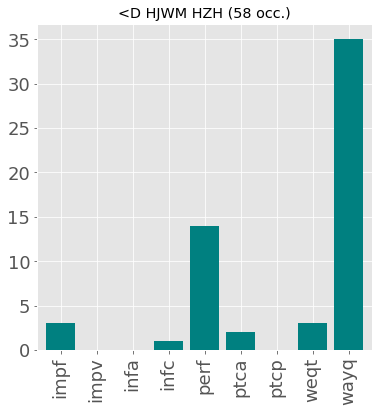

In [150]:
until_today = pd.Series(init_verbs['<D H JWM H ZH'], index=all_tenses)
until_forever = pd.Series(init_verbs['<D <WLM'], index=all_tenses)

until_today.plot.bar(figsize=(6,6), 
                       color='teal', 
                       width = .8,
                       fontsize=18,
                       title='<D HJWM HZH (58 occ.)'
                    )

plt.savefig('until_today.png', dpi = 300)

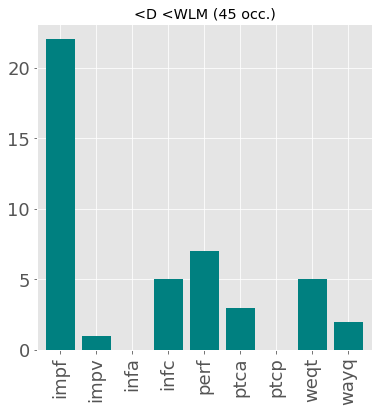

In [149]:
until_forever.plot.bar(figsize=(6,6), 
                       color='teal', 
                       width=.8,
                       fontsize=18,
                       title='<D <WLM (45 occ.)'
                      )

plt.savefig('until_forever.png', dpi = 300)